## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

patience = [10 , 25]

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for patience in patience:
  model = build_mlp(input_shape=x_train.shape[1:])
  optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
  model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)
  
  earlystop = EarlyStopping(monitor="val_acc", 
                          patience= patience, 
                          verbose=1
                          )
  
  model.fit(x_train, y_train, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(x_test, y_test), 
            shuffle=True,
            callbacks=[earlystop]
          )

  # Collect results
  train_loss = model.history.history["loss"]
  valid_loss = model.history.history["val_loss"]
  train_acc = model.history.history["acc"]
  valid_acc = model.history.history["val_acc"]

  exp_name_tag = "exp-patience-%s" % str(patience)
  results[exp_name_tag] = {'train-loss': train_loss,
                           'valid-loss': valid_loss,
                           'train-acc': train_acc,
                           'valid-acc': valid_acc}



Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 1s 26us/step - loss: 2.2193 - acc: 0.2677 - val_loss: 2.1547 - val_acc: 0.1904
Epoch 2/20
50000/50000 [==============================] - 1s 20us/step - loss: 1.7430 - acc: 0.3950 - val_loss: 1.9944 - val_acc: 0.2807
Epoch 3/20
50000/50000 [==============================] - 1s 20us/step - loss: 1.6228 - acc: 0.4329 - val_loss: 1.8253 - val_acc: 0.3755
Epoch 4/20
50000/50000 [==============================] - 1s 20us/step - loss: 1.5505 - acc: 0.4584 - val_loss: 1.7166 - val_acc: 0.4027
Epoch 5/20
50000/50000 [==============================] - 1s 20us/step - loss: 1.4966 - acc: 0.4762 - val_loss: 1.6272 - val_acc: 0.4347
Epoch 6/20
50000/50000 [==============================] - 1s 20us/step - loss: 1.4500 - acc: 0.4931 - val_loss: 1.5828 - val_acc: 0.4432
Epoch 7/20
50000/50000 [==============================] - 1s 20us/step - loss: 1.4124 - acc: 0.5042 - val_loss: 1.5423 - val_acc

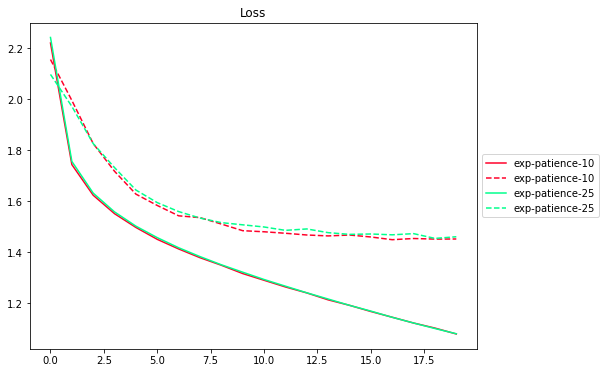

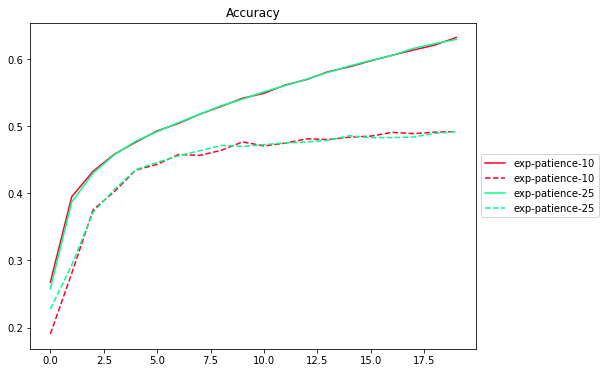

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()